In [14]:
!pip install pandas numpy matplotlib seaborn scikit-learn joblib

Import Libraries

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


Load Dataset

In [16]:
df = pd.read_csv("/content/Titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

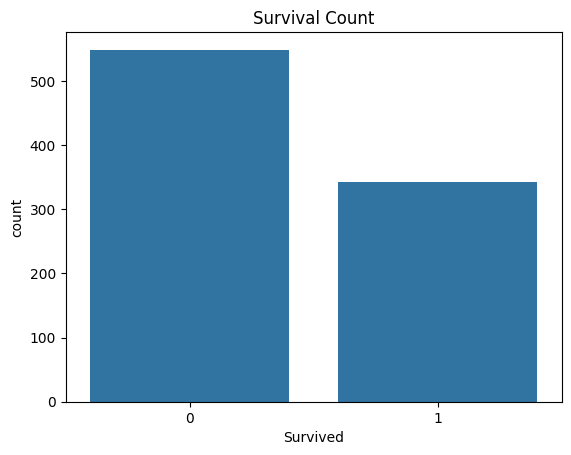

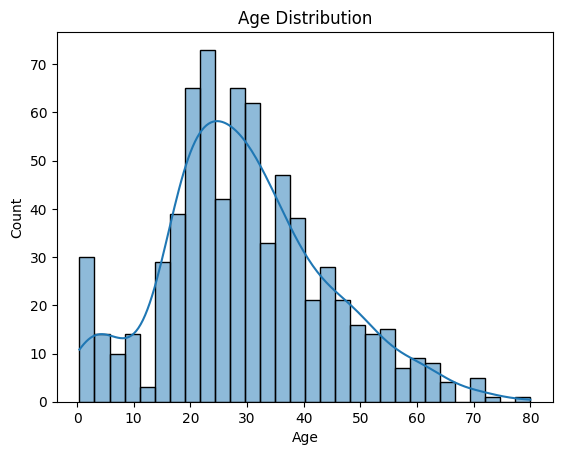

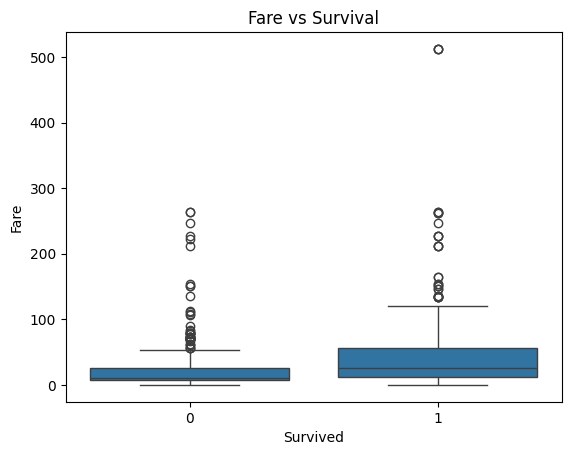

In [17]:
print(df.info())
print(df.describe())

# Missing values
missing = df.isnull().sum()
print("Missing Values:\n", missing)

# Visualisations
sns.countplot(x='Survived', data=df)
plt.title("Survival Count")
plt.show()

sns.histplot(df['Age'].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

sns.boxplot(x='Survived', y='Fare', data=df)
plt.title("Fare vs Survival")
plt.show()

Handle Missing Values

In [18]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df.drop(columns=['Cabin'], inplace=True)

/tmp/ipython-input-1987171107.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-1987171107.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

Feature Engineering

In [19]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = 1  # Initialize to yes/1
df['IsAlone'].loc[df['FamilySize'] > 1] = 0

# Encode categorical variables
label = LabelEncoder()
for col in ['Sex', 'Embarked']:
    df[col] = label.fit_transform(df[col])

/tmp/ipython-input-1756619998.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['IsAlone'].loc[df['FamilySize'] > 1] = 0
/tmp/ipython-input-1756619998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

Select Features & Target

In [20]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']
target = 'Survived'

X = df[features]
y = df[target]

Split Data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Train Models

In [22]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='linear', probability=True, random_state=42)
}

results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = scores.mean()
    print(f"{name} CV Accuracy: {scores.mean():.4f}")

Random Forest CV Accuracy: 0.7894
Logistic Regression CV Accuracy: 0.8047
SVM CV Accuracy: 0.7935


Select Best Model

Best Model: Logistic Regression
Test Accuracy: 0.7988826815642458
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



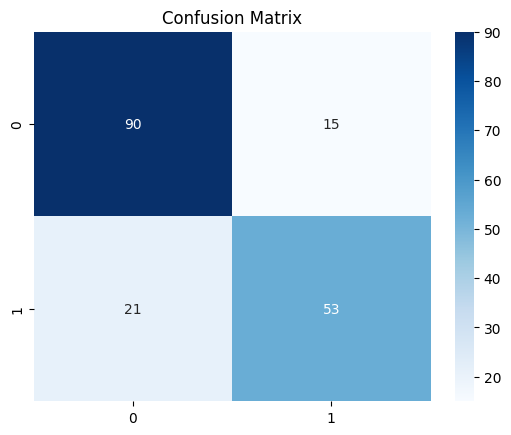

In [23]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(f"Best Model: {best_model_name}")
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

Save Best Model

In [24]:
joblib.dump(best_model, "best_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model and scaler saved successfully!")

Model and scaler saved successfully!
